In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd_87.png
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.mhd_25.png
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/65%4.jpg
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/54%1.jpg
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/Non-Covid (1153).png
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd_227.png
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/Non-COVID/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196.mhd_94.png
/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Datas

Found 1050 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 670ms/step - accuracy: 0.6031 - loss: 0.7210 - val_accuracy: 0.6667 - val_loss: 0.6288
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.6272 - loss: 0.6528 - val_accuracy: 0.6667 - val_loss: 0.6242
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.7028 - loss: 0.5673 - val_accuracy: 0.6867 - val_loss: 0.6293
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.7353 - loss: 0.5198 - val_accuracy: 0.6711 - val_loss: 0.6484
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.8089 - loss: 0.4530 - val_accuracy: 0.6689 - val_loss: 0.7060
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.8641 - loss: 0.3906 - val_accuracy: 0.6444 - val_loss: 0.7718
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8933 - loss: 0.3376 - val_accuracy: 0.6333 - val_loss: 0.8557
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.9215 - loss: 0.2753 - val_accuracy: 0.6000 - val

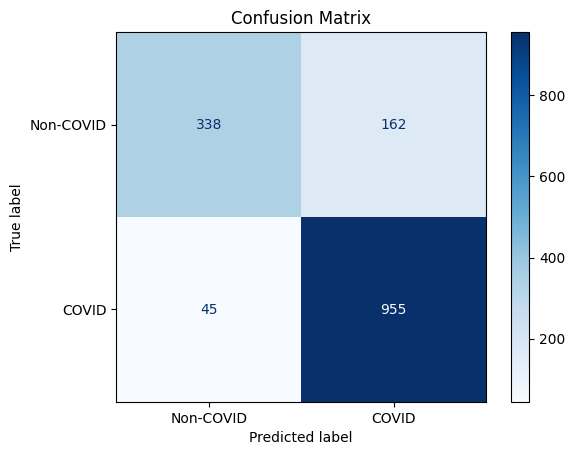

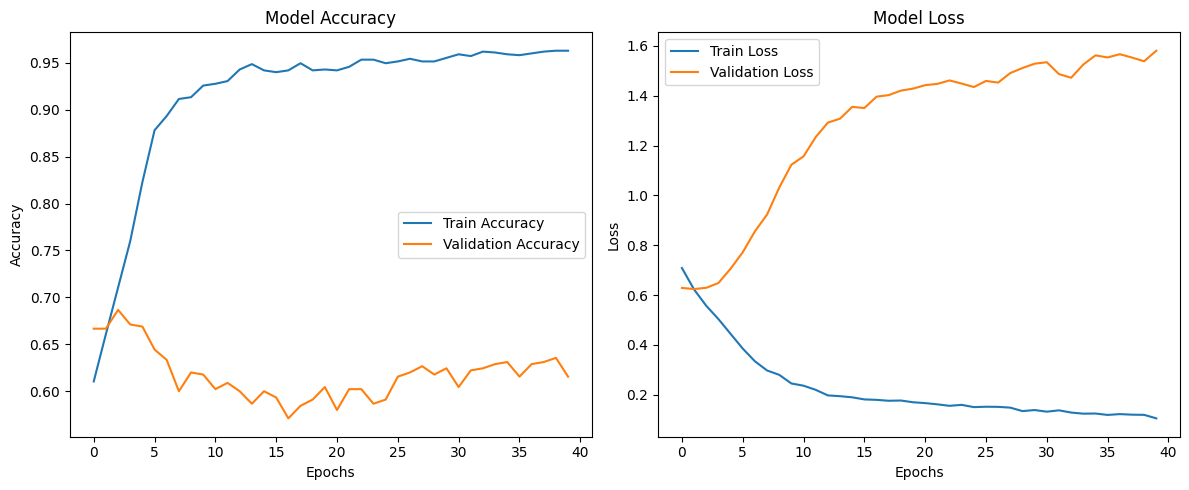

In [2]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Paths
DATASET_PATH = '/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset'
COVID_PATH = os.path.join(DATASET_PATH, 'CT/COVID')
NORMAL_PATH = os.path.join(DATASET_PATH, 'CT/Non-COVID')
TEMP_PATH = '/kaggle/working/temp_dataset'

# Ensure temporary dataset structure
if not os.path.exists(TEMP_PATH):
    os.makedirs(os.path.join(TEMP_PATH, 'COVID'), exist_ok=True)
    os.makedirs(os.path.join(TEMP_PATH, 'NORMAL'), exist_ok=True)

if not os.path.exists(COVID_PATH) or not os.path.exists(NORMAL_PATH):
    raise FileNotFoundError("Dataset folders 'COVID' or 'Non-COVID' not found. Ensure the dataset is correctly structured.")

covid_files = [file for file in os.listdir(COVID_PATH) if file.endswith(('png', 'jpg', 'jpeg'))]
normal_files = [file for file in os.listdir(NORMAL_PATH) if file.endswith(('png', 'jpg', 'jpeg'))]

if len(covid_files) < 500 or len(normal_files) < 1000:
    raise ValueError("Insufficient images in the dataset. Ensure at least 500 COVID and 1000 Non-COVID images are available.")

covid_files = covid_files[:500]
normal_files = normal_files[:1000]

for file in covid_files:
    shutil.copy(os.path.join(COVID_PATH, file), os.path.join(TEMP_PATH, 'COVID', file))

for file in normal_files:
    shutil.copy(os.path.join(NORMAL_PATH, file), os.path.join(TEMP_PATH, 'NORMAL', file))

# Verify copied files
if len(os.listdir(os.path.join(TEMP_PATH, 'COVID'))) == 0 or len(os.listdir(os.path.join(TEMP_PATH, 'NORMAL'))) == 0:
    raise ValueError("Temporary dataset folders are empty. Check file copying logic.")

# Split data
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_gen = data_gen.flow_from_directory(
    TEMP_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

valid_gen = data_gen.flow_from_directory(
    TEMP_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

data_gen_test = ImageDataGenerator(rescale=1./255)
test_gen = data_gen_test.flow_from_directory(
    TEMP_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Check data generators
if len(train_gen.filepaths) == 0 or len(valid_gen.filepaths) == 0 or len(test_gen.filepaths) == 0:
    raise ValueError("One or more data generators are empty. Check dataset paths and splits.")

# Load ResNet101 Model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=40
)

print("Test Evaluation:")
results = model.evaluate(test_gen)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

# Predict and evaluate
predictions = (model.predict(test_gen) > 0.5).astype(int)
y_true = test_gen.classes

# Classification report
report = classification_report(y_true, predictions, target_names=['Non-COVID', 'COVID'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, predictions)
ConfusionMatrixDisplay(cm, display_labels=['Non-COVID', 'COVID']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
